# Anti Collision Tests Environment - openai gym compatible

In [1]:
import numpy as np
import cv2
import math

In [2]:
import matplotlib.pyplot as plt

In [3]:
def show_img(img):
    plt.imshow(img)
    plt.show()
    
def  resize_images(images, f=3):
    big_images = []
    for img in images:
        big_images.append(cv2.resize(img, None, fx=f, fy=f))
    return big_images

In [4]:
plt.rcParams["figure.figsize"]=10,10

#  Some useful functions

In [5]:
def get_dist(obj1, obj2):
    return math.sqrt((obj1[0]-obj2[0])**2 + (obj1[1]-obj2[1])**2)

In [6]:
def get_dist_nearest_obj(s):
    nobjs = int(len(s)/4 - 1)
    ego = s[0:4]
    
    dist_nearest_obj = math.inf
    num_nearest_obj = -1
    
    idx = 4
    for n in range(nobjs):
        obj = s[idx:idx+4]
        dist = get_dist(ego, obj)
        
        if dist < dist_nearest_obj:
            dist_nearest_obj = dist
            num_nearest_obj = n
        idx += 4
    
    return dist_nearest_obj

In [7]:
def get_dist_to_goal(s, goal):
    return get_dist(s[0:4], goal)

# Time To Collision

In [8]:
def get_TTC(ego, obj, radius):
    x1, y1, vx1, vy1 = ego[0], ego[1], ego[2], ego[3]
    x2, y2, vx2, vy2 = obj[0], obj[1], obj[2], obj[3]

    a = (vx1 - vx2) **2 + (vy1 - vy2) **2
    b = 2 * ((x1 - x2) * (vx1 - vx2) + (y1 - y2) * (vy1 - vy2))
    c = (x1 - x2) **2 + (y1 - y2) **2 - radius **2

    if a == 0 and b == 0:
        if c == 0:
            return 0
        else:
            return np.inf

    if a == 0 and b != 0:
        t = -c / b
        if t < 0:
            return np.inf
        else:
            return t

    delta = b **2 - 4 * a * c
    if delta < 0:
        return np.inf

    t1 = (-b - np.sqrt(delta)) / (2 * a)
    t2 = (-b + np.sqrt(delta)) / (2 * a)
    if t1 < 0:
        t1 = np.inf

    if t2 < 0:
        t2 = np.inf

    return min(t1, t2)

In [9]:
def get_smallest_TTC(s):
    radius = 15.0
    ego = s[0:4]
    
    smallest_TTC = np.Inf
    smallest_TTC_obj = -1
    
    idx = 4
    for n in range(int((len(s)-4)/4)):
        obj = s[idx:idx+4]
        TTC = get_TTC(ego, obj, radius)
        
        if TTC < smallest_TTC:
            smallest_TTC = TTC
            smallest_TTC_obj = n
        idx += 4
    
    return smallest_TTC, smallest_TTC_obj

In [10]:
# just checking
obj1 = np.array([0.0, 100, 20, 0])
obj2 = np.array([100, 0.0, 0, 20])
print("dist: ", get_dist(obj1, obj2))
print("TTC: ", get_TTC(obj1, obj2, 15.0))


dist:  141.4213562373095
TTC:  4.4696699141100895


# Openai gym Anti Collision Test Env

In [35]:
##################################################################
# Anti Collision Tests env compatible with gym openai interface
##################################################################

# API eg https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py


import gym
from gym import spaces, logger
from gym.utils import seeding

import math
import numpy as np
import cv2
import copy

def draw_arrow(image, p, q, color, arrow_magnitude=5, thickness=1, line_type=4, shift=0):
    # adapted from http://mlikihazar.blogspot.com.au/2013/02/draw-arrow-opencv.html
    # draw arrow tail
    cv2.line(image, p, q, color, thickness, line_type, shift)
    # calc angle of the arrow
    angle = np.arctan2(p[1]-q[1], p[0]-q[0])
    # starting point of first line of arrow head
    p = (int(q[0] + arrow_magnitude * np.cos(angle + np.pi/4)),
    int(q[1] + arrow_magnitude * np.sin(angle + np.pi/4)))
    # draw first half of arrow head
    cv2.line(image, p, q, color, thickness, line_type, shift)
    # starting point of second line of arrow head
    p = (int(q[0] + arrow_magnitude * np.cos(angle - np.pi/4)),
    int(q[1] + arrow_magnitude * np.sin(angle - np.pi/4)))
    # draw second half of arrow head
    cv2.line(image, p, q, color, thickness, line_type, shift)

# Transition with Constant Acceleration model
def transition_ca(s, a, dt=0.2):
    Ts = np.matrix([[1.0, 0.0, dt,  0.0], 
                [0.0, 1.0, 0.0, dt],
                [0.0, 0.0, 1.0, 0.0],
                [0.0, 0.0, 0.0, 1.0]])
    Ta = np.matrix([[0.5*dt**2, 0.0],
                [0.0,      0.5*dt**2],
                [dt,       0.0],
                [0.0,      dt]])
    return np.dot(Ts, s) + np.dot(Ta, a)


class ActEnv(gym.Env):
    def __init__(self, nobjs, max_accel=2, dist_collision=10):    
        self.nobjs = nobjs
        self.max_accel = max_accel
        self.dist_collision = dist_collision
        
        self.action_space = spaces.Box(low=-self.max_accel, high=self.max_accel, shape=(1,))
        # 1+nobjs: x,y,vx,vy with x,y in [0,200] and vx,vy in [0,40]
        self.observation_space = spaces.Box(low=0.0, high=200.0, shape=((1+nobjs)*4,))
        
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
        
    def reset(self):
        self.reward = None
        self.steps = 0
        self.smallest_TTC_obj = -1
        
        # x, y, vx, vy
        self.start = np.array([100.0,   0.0,  0.0,  20.0], dtype=int)
        self.goal  = np.array([100.0, 200.0, 0.0, 0.0], dtype=int)
        # states init
        state = ego = self.start
        for n in range(int(self.nobjs/2)):
            x = self.np_random.randint(low=0, high=50)
            y = self.np_random.randint(low=25, high=190)
            vx = self.np_random.randint(low=10, high=25)
            vy = self.np_random.randint(low=0, high=5)
            obj = np.array([x, y, vx, vy])
            state = np.append(state, obj)
        
        for n in range(int(self.nobjs/2)):
            x = self.np_random.randint(low=150, high=200)
            y = self.np_random.randint(low=25, high=190)
            vx = - self.np_random.randint(low=10, high=25)
            vy = - self.np_random.randint(low=0, high=5)
            obj = np.array([x, y, vx, vy])
            state = np.append(state, obj)     
        print(state)  
        self.s = state
        
        return self.s
    
    # TODO reward shaping and reward basic
    def _reward(self, s, a, sp):
        # Keep track for visualization, plots ...
        self.dist_to_goal = get_dist_to_goal(sp, self.goal)
        self.dist_nearest_obj = get_dist_nearest_obj(sp)
        self.smallest_TTC, self.smallest_TTC_obj = get_smallest_TTC(sp)

        # We are dealiong with 3 types of objectives:
        # - COMFORT (weiht 1)
        # - EFFICIENCY (weight 10)
        # - SAFETY (weight 100)

        r_comfort = r_efficiency = r_safety = 0

        if self.smallest_TTC <= 10.0:
            r_safety += -10 - (10 - self.smallest_TTC) * 10 # between [-100, -10]

        # SAFETY related + terminal state (overwrite)
        if self.dist_nearest_obj <= self.dist_collision:
            r_safety += -1000

        # The faster we go in this test setup
        r_efficiency += a

        if a < -2:
            r_comfort += -1

        # Keep track for visualization, plots ...
        self.r_comfort = r_comfort
        self.r_efficiency = r_efficiency
        self.r_safety = r_safety

        return r_comfort + r_efficiency + r_safety
        
    def render(self):
        pos_left = 40
        #color_text = (255,255,255)
        color_text = (0,0,0)
        img = np.zeros([250, 250, 3],dtype=np.uint8)
        img.fill(255) # or img[:] = 255
        cv2.putText(img, 'Anti Collision Tests', (pos_left, 240), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))
        
        x = self.s[0]; y = self.s[1]; vx = self.s[2]; vy = self.s[3]; v = int(math.sqrt(vx**2 + vy**2)*3.6)
        color = (0, 0, 255) # blue
        cv2.circle(img, (x, y), 2, color, -1)
        draw_arrow(img, (int(x), int(y)), (int(x+vx), int(y+vy)), color)        
        cv2.putText(img, str(v) + ' kmh', (x+vx+5, y+vy), cv2.FONT_HERSHEY_SIMPLEX, 0.25, color)
        
        for i in range(self.nobjs):
            if i == self.smallest_TTC_obj:
                color = (255, 0, 0) # red
            else:
                color = (0, 2500, 0) # green
            idx = (i+1)*4
            x = self.s[idx]; y = self.s[idx+1]; vx = self.s[idx+2]; vy = self.s[idx+3]; v = int(math.sqrt(vx**2 + vy**2)*3.6)
            cv2.circle(img, (x, y), 2, color, -1)
            draw_arrow(img, (int(x), int(y)), (int(x+vx), int(y+vy)), color)        
            cv2.putText(img, str(v) + ' kmh', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.25, color_text)
        
        if self.reward is not None:
            str_reward = "R_com %.2f , R_eff %.2f R_saf %.2f" % (self.r_comfort, self.r_efficiency, self.r_safety)
            cv2.putText(img, str_reward, (pos_left, 205), cv2.FONT_HERSHEY_SIMPLEX, 0.25, color_text)
        
            str_safety = "TTC %.2f seconds, D_min %.2f meters" % (self.smallest_TTC, self.dist_nearest_obj)
            cv2.putText(img, str_safety, (pos_left, 215), cv2.FONT_HERSHEY_SIMPLEX, 0.25, color_text)
            
            str_step = "Step %d with action %d reward %.2f" % (self.steps, self.action, self.reward)
            cv2.putText(img, str_step, (pos_left, 225), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0,0,255))
        
        #img = cv2.resize(img, None, fx=20, fy=20)
        #img = cv2.resize(img,(2500, 2500))
        return img
        
    #state, reward, done, info = env.step(action)
    def step(self, action):
        reward = -1; done = False        
        sp = copy.copy(self.s)
        
        s = self.s[0:4]
        a = np.array([0.0, action])
        sp[0:4] = transition_ca(s, a)
        
        idx = 4
        for n in range(self.nobjs):
            s_obj = self.s[idx:idx+4]
            a_obj = np.array([0.0, 0.0]) # TODO CALL Driving Model
            sp[idx:idx+4] = transition_ca(s_obj, a_obj)
            idx += 4
            
        reward = self._reward(self.s, action, sp)
        
        self.s = sp
        self.action = action
        self.reward = reward
        self.steps += 1
        
        if self.dist_nearest_obj <= self.dist_collision or self.s[1] >= self.goal[1]:
            print("done: dist_nearest_obj {}, y-ego {}".format(self.dist_nearest_obj, self.s[1]))
            done = True
            
        return self.s, reward, done, {}
    
    def close(self):
        return

In [36]:
env = ActEnv(10)

[100   0   0  20   9  56  11   3   3  39  14   4  26  84  18   4  36 121
  11   4  11 187  19   1 189 132 -18   0 191 158 -17  -1 160  90 -12  -4
 160 188 -19  -1 176  60 -20  -1]


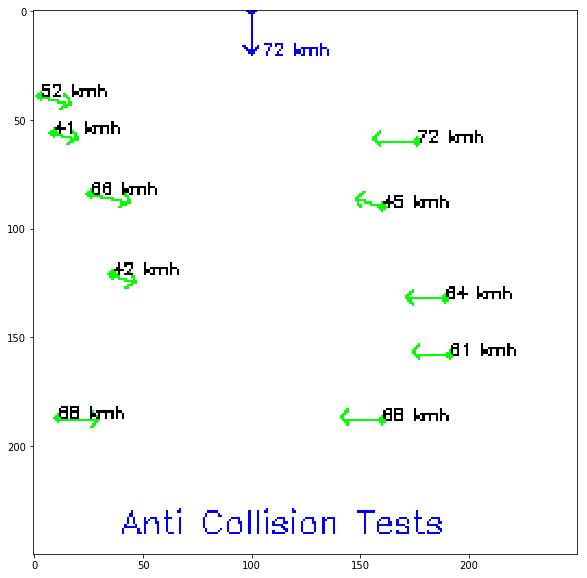

In [37]:
img = env.render()

plt.imshow(img)
plt.show()

In [38]:
pipo = np.arange(20)

In [43]:
max_episodes = 3
max_steps = 20

for episode in range(max_episodes):
    print("====> Start episode {}".format(episode))
    env.reset()
    cumulated_reward = 0
    images = []
    for n in range(max_steps):
        action = 0.0
        state, reward, done, info = env.step(action)
        cumulated_reward += reward
        print("Step {}: action={} reward={} done={}".format(n, action, reward, done)) # PHW DEBUG
        img = env.render()
        images.append(img)
        if done is True:
            print("End of episode {} with cumulated_reward {}".format(episode, cumulated_reward))
            break

====> Start episode 0
[100   0   0  20   1 164  21   1  47  53  16   0  40 151  17   3  36 164
  23   0  10 184  23   0 167 117 -20  -3 154  38 -15  -3 190 183 -15  -2
 153 136 -11  -4 169 114 -15  -2]
Step 0: action=0.0 reward=-87.70909840056356 done=False
Step 1: action=0.0 reward=-89.61829748415354 done=False
Step 2: action=0.0 reward=-91.52634418899986 done=False
Step 3: action=0.0 reward=-93.4332068512409 done=False
Step 4: action=0.0 reward=-95.33885171839589 done=False
Step 5: action=0.0 reward=-97.24324276134058 done=False
Step 6: action=0.0 reward=-99.14634146341463 done=False
Step 7: action=0.0 reward=-101.04810658316863 done=False
Step 8: action=0.0 reward=-102.94849388660813 done=False
Step 9: action=0.0 reward=-104.84745584399802 done=False
Step 10: action=0.0 reward=-106.74494128531558 done=False
Step 11: action=0.0 reward=-108.64089500723506 done=False
Step 12: action=0.0 reward=-102.02571828672696 done=False
Step 13: action=0.0 reward=-104.03545108924749 done=False
Step

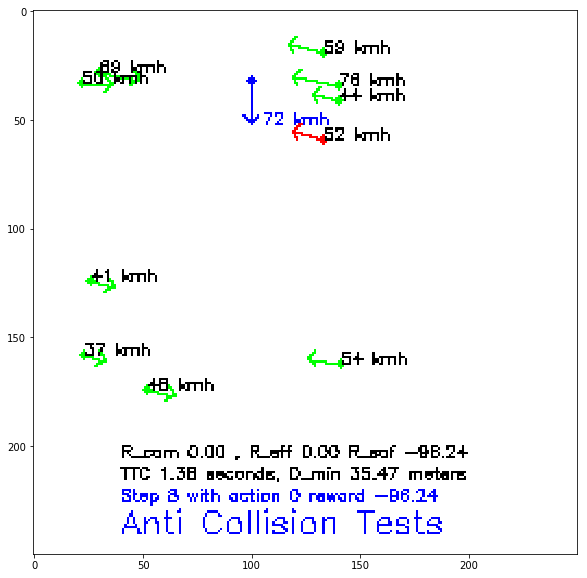

In [44]:
show_img(images[7])

# Visualization

In [45]:
import imageio
from IPython.core.display import HTML

In [46]:
imageio.mimsave('img/visu.gif', images, duration=0.2)
HTML("""<img src="img/visu.gif"/>""")

In [47]:
big_images = resize_images(images, f=2)
imageio.mimsave('img/visu2.gif', big_images, duration=0.2)
HTML("""<img src="img/visu2.gif"/>""")